In [1]:
import warnings

import numpy as np
import pylab as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
warnings.filterwarnings('ignore')

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

In [4]:
seq = keras.Sequential(
    [
        keras.Input(
            shape = (None, 40, 40, 1)
        ),  
        layers.ConvLSTM2D(
            filters = 40, kernel_size = (3, 3), padding = "same", return_sequences = True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters = 40, kernel_size = (3, 3), padding = "same", return_sequences = True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters = 40, kernel_size = (3, 3), padding = "same", return_sequences = True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters = 40, kernel_size = (3, 3), padding = "same", return_sequences = True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters = 1, kernel_size = (3, 3, 3), activation = "sigmoid", padding = "same"
        ),
    ]
)

seq.compile(loss = "binary_crossentropy", optimizer = "adadelta")

In [5]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  1

### Generate artificial data
Generate movies with 3 to 7 moving squares inside. The squares are of shape 1x1 or 2x2 pixels, and move linearly over time. For convenience, we first create movies with bigger width and height (80x80) and at the end we select a 40x40 window.

In [6]:
def generate_movies(n_samples = 1200, n_frames = 15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype = np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype = np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [7]:
epochs = 1  

noisy_movies, shifted_movies = generate_movies(n_samples = 1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size = 10,
    epochs = epochs,
    verbose = 1,
    validation_split = 0.1,
)

90/90 [==============================] - 41s 455ms/step - loss: 0.7487 - val_loss: 0.6889


In [8]:
movie_index = 1004
test_movie = noisy_movies[movie_index]

# Start from first 7 frames
track = test_movie[:7, ::, ::, ::]

# Predict 16 frames
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis = 0)

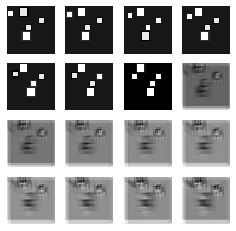

In [9]:
### First 7 frames are the actual image, next 9 are predicitons

fig = plt.figure(figsize = (4,4))

for i in range(track.shape[0] - 7):
  plt.subplot(4, 4, i+1)
  plt.imshow(track[i, :, :, 0], cmap = 'gray')
  plt.axis('off')

plt.show()